<a href="https://colab.research.google.com/github/stavIatrop/Fake-News-Detection/blob/master/lstm_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import and split the data

In [45]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

data = pd.read_csv("drive/My Drive/datasets/politifact.csv", ",")
data_labels = data['label'].values
data = data['text'].values

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(data, data_labels):
    X_train, X_test = data[train_index], data[test_index]
    Y_train, Y_test = data_labels[train_index], data_labels[test_index]

print("Train shape : ",X_train.shape)
print("Test shape : ",X_test.shape)

Train shape :  (559,)
Test shape :  (140,)


Preprocess the data.

In [0]:
import re

def remove_non_ascii(X):
  for i in range(len(X)):
    words = X[i].split()
    filtered_list = []
    for word in words:
        pattern = re.compile('[^\u0000-\u007F]+', re.UNICODE)  #Remove all non-alphanumeric characters
        
        word = pattern.sub(" ", word)
        filtered_list.append(word)
        result = ' '.join(filtered_list)
        
    X[i] = result
  return X

def toLowerCase(X):

  for i in range(len(X)):
    filtered_list = []
    for word in X[i].split():
      word = word.lower()
      filtered_list.append(word)
      result = ' '.join(filtered_list)

    X[i] = result
  
  return X

import string

def handle_punctuation(X):

  for i in range(len(X)):
    filtered_list = []
    
    for word in X[i].split():
      
      cleaned = 0
      
      while(not cleaned):
        punc_word = ""

        if (word[0] in string.punctuation):
          punc_word = word[0]
          if (len(word) == 1):
            cleaned = 1
          else:
            word = word[1:]
          filtered_list.append(punc_word)
          result = ' '.join(filtered_list)
        elif (word[len(word) - 1] in string.punctuation):
          punc_word = word[len(word) - 1]
          word = word[:len(word) - 1]
          filtered_list.append(punc_word)
          result = ' '.join(filtered_list)
        else:
          #word = word.translate(str.maketrans(' ', ' ', string.punctuation))
          t = str.maketrans(dict.fromkeys(string.punctuation, " "))
          word = word.translate(t)
          cleaned = 1
          filtered_list.append(word)
          result = ' '.join(filtered_list)
    
    X[i] = result
  
  return X

def clean_numbers(X):
  for i in range(len(X)):
    x = X[i]
    if bool(re.search(r'\d', x)):
      x = re.sub('[0-9]{4,}', ' ### ', x)
      x = re.sub('[0-9]{3}', ' ## ', x)
      x = re.sub('[0-9]{2}', ' # ', x)
    X[i] = x
  return X

def preprocess_text(X):

  #remove non ascii characters
  X = remove_non_ascii(X)
  #transform to lower case
  X = toLowerCase(X)
  #handle punctuation
  X = handle_punctuation(X)
  #clean numbers
  X = clean_numbers(X)
  return X

In [0]:
X_train = preprocess_text(X_train)
X_test = preprocess_text(X_test)

Load GloVe embeddings and create word index

In [0]:
import numpy as np
def load_glove_index():
    word2idx = dict()
    embeddings_index = dict()
    idx = 0
    EMBEDDING_FILE = "/content/drive/My Drive/GloVe/glove.6B.50d.txt"
    for f in open(EMBEDDING_FILE):
      line = f.split(" ")
      word = line[0]
      word2idx[word] = idx
      idx += 1
      embeddings_index[word] = np.array(line[1:]).astype(np.float)
    return embeddings_index, word2idx

In [0]:
embeddings_index, word2idx = load_glove_index()

In [50]:
embeddings_index[(list(word2idx.keys())[len(word2idx)-1])]  #last token is the unknown token


array([-0.12920076, -0.28866628, -0.01224866, -0.05676644, -0.20210965,
       -0.08389011,  0.33359843,  0.16045167,  0.03867431,  0.17833012,
        0.04696583, -0.00285802,  0.29099807,  0.04613704, -0.20923874,
       -0.06613114, -0.06822549,  0.07665912,  0.3134014 ,  0.17848536,
       -0.1225775 , -0.09916983, -0.07495987,  0.06413227,  0.14441176,
        0.60894334,  0.17463093,  0.05335403, -0.01273871,  0.03474107,
       -0.8123879 , -0.04688699,  0.20193407,  0.2031118 , -0.03935686,
        0.06967544, -0.01553638, -0.03405238, -0.06528071,  0.12250231,
        0.13991883, -0.17446303, -0.08011883,  0.0849521 , -0.01041659,
       -0.13705009,  0.20127155,  0.10069407,  0.00653003,  0.01685157])

Build the training vocab.

In [0]:
def build_vocab(X):
  sentences = [row.split() for row in X]     #sentences --> list of lists of tokens
  vocab = dict()
  for sentence in sentences:
    for word in sentence:
      if word in vocab.keys():
        vocab[word] += 1
      else:
        vocab[word] = 1
  return vocab

In [52]:
vocab = build_vocab(X_train)
print({k: vocab[k] for k in list(vocab)[:10]})

{'george': 240, '.': 51896, 'w': 68, 'bush': 399, 'has': 3036, 'lobbed': 3, 'thinly': 3, 'veiled': 5, 'critiques': 2, 'of': 21340}


Build the embedding weight map with the indices. (either using only vocabulary words or all the pretrained embeddings)

In [0]:
import numpy as np

def build_embedding_weight_matrix( vocab, embeddings_index, word2idx, usevoc = True):
  EMBEDDING_DIM = 50
  if (usevoc):
    word2idx.clear()
    weight_matrix = np.zeros((len(vocab) + 1, EMBEDDING_DIM), dtype=float)
    for idx, word in enumerate(vocab):
      word2idx[word] = idx
      if word in embeddings_index.keys():
        weight_matrix[idx] = embeddings_index[word]
      else:
        #store in a variable one idx representing an unknown token for later use in generating batches
        idx_unknown = idx
        weight_matrix[idx] = embeddings_index["unknown_emb"]
    
    word2idx["pad_token"] = len(vocab)
    weight_matrix[len(vocab)] = np.zeros(EMBEDDING_DIM)     #pad token
  else:
    idx_unknown = -1
    weight_matrix = np.zeros((len(embeddings_index) + 1, EMBEDDING_DIM), dtype=float)
    for idx, word in enumerate(embeddings_index):
      weight_matrix[idx] = embeddings_index[word]

    word2idx["pad_token"] = len(vocab)
    weight_matrix[len(embeddings_index)] = np.zeros(EMBEDDING_DIM)    #pad token
    
  
  
  return weight_matrix, idx_unknown

In [54]:
emb_weight_matrix, idx_unk = build_embedding_weight_matrix(vocab, embeddings_index, word2idx, True)
emb_weight_matrix[0:5]
emb_weight_matrix.shape

(22942, 50)

Split train and valid data set.

In [55]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train_index, valid_index in sss.split(X_train, Y_train):
  train_X, X_valid = X_train[train_index],X_train[valid_index]
  train_Y, Y_valid = Y_train[train_index] ,Y_train[valid_index]

print("Train shape : ",train_X.shape)
print("Valid shape : ",X_valid.shape)
print("Test shape : ",X_test.shape)

Train shape :  (447,)
Valid shape :  (112,)
Test shape :  (140,)


Encode documents' text.

In [0]:
def encode_documents(X, word2idx):

  sentences = [row.split() for row in X]
  for sentence in sentences:
    for i in range(len(sentence)):
      if ( sentence[i] in word2idx.keys() ):
        sentence[i] = word2idx[sentence[i]]
      else:
        sentence[i] = word2idx["unknown_emb"]
  return sentences 


In [57]:
print ([row.split() for row in train_X[:5]])

X_train = encode_documents(train_X, word2idx)
X_valid = encode_documents(X_valid, word2idx)

[['brian', 'kline', 'is', 'the', 'type', 'of', 'person', 'who', 'voted', 'for', 'president', 'donald', 'trump', 'in', '.', 'november', 'he', 's', 'a', 'working', 'class', 'man', 'whose', 'job', 'is', 'in', ',', 'retail', 'scoring', 'him', '$', '.', '#', '#', 'hour', 'thanks', 'to', 'medicaid', 'he', 's', 'being', 'treated', 'for', '.', 'cancer', 'during', 'the', 'cnn', 'town', 'hall', 'with', 'health', 'and', 'human', 'services', 'secretary', 'tom', ',', 'price', 'kline', 'explained', 'his', 'situation', 'and', 'his', '.', 'struggles', 'my', 'question', 'is', 'pretty', ',', 'straightforward', 'kline', 'told', '.', 'price', 'why', 'do', 'you', 'want', 'to', 'take', 'away', 'my', 'medicaid', '?', 'expansion', 'price', 's', 'dispassionate', 'answer', 'seemed', 'to', 'fall', 'flat', 'on', 'the', '.', 'audience', 'i', 'took', 'care', 'of', 'a', 'lot', 'of', 'patients', 'with', ',', 'cancer', 'price', 'explained', 'about', 'his', '#', 'years', 'as', 'an', 'orthopedic', '.', 'surgeon', 'we', 

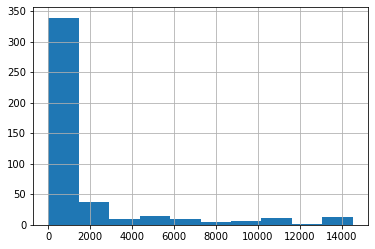

count      447.000000
mean      1852.152125
std       3159.777389
min         11.000000
25%        295.000000
50%        587.000000
75%       1356.500000
max      14534.000000
dtype: float64

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_X_lens = [len(x) for x in X_train]
pd.Series(train_X_lens).hist()
plt.show()
pd.Series(train_X_lens).describe()

Generate Batches

In [0]:
import random 
import torch
from sklearn.utils import shuffle

def generate_batches(data, labels, seq_len, batch_size, idx_unk):
  #first shuffle the data and labels in parallel!!!!!!!!!
  data_shu, labels_shu = shuffle(data, labels)
  
  slice_start = 0
  slice_end = batch_size
  num_batches = len(data_shu) // batch_size   #drop the last batch
  
  
  for i in range(num_batches):    

      batch = np.zeros((batch_size, seq_len), dtype="int")
      #get slice of data
      slice_data = data_shu[slice_start:slice_end]
      ret_labels = labels_shu[slice_start:slice_end]
      for j, slice_d in enumerate(slice_data):
        
        if seq_len >= len(slice_d):     #if text is longer than the sequence length set, padding with the unknown word token

          if idx_unk == -1:
            #pad_seq = list(np.full(seq_len - len(slice_d), word2idx["unknown_emb"]))   #pad sequence with unknown token
            pad_seq = list(np.full(seq_len - len(slice_d), word2idx["pad_token"]) )      #or pad with zeros
          else:
            #pad_seq = list(np.full(seq_len - len(slice_d), idx_unk))                   #pad sequence with the index of a word that maps to unknown token
            pad_seq = list(np.full(seq_len - len(slice_d), word2idx["pad_token"] ) )      #or pad with zeros

          new_len =  slice_d +  pad_seq       #pad sequence at the end of document
          batch[j:] = np.array(new_len)
        
        else:   #sample the text

          rand_start = random.randrange(0, len(slice_data[j]) - seq_len)
          new_len = slice_d[rand_start : rand_start + seq_len]
          batch[j:] = np.array(new_len)

      batch = torch.from_numpy(batch)
      ret_labels = torch.from_numpy(ret_labels)
      yield batch, ret_labels

      slice_start = slice_end
      slice_end = slice_end + batch_size


Define neural network architecture.

In [0]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class OneLayerModel(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embeddings_matrix ):
    super(OneLayerModel, self).__init__()

    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim
    self.output_size = output_dim
    self.n_layers = 1
    #embedding layer
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)

    #lstm layer
    self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim, batch_first = True )

    #dense layer
    self.fc = nn.Linear(hidden_dim, output_dim)

    #sigmoid activation function
    self.sig = nn.Sigmoid()

    self.init_weigths(embeddings_matrix)
  
  def init_weigths(self, embeddings_matrix):
    self.embeddings.weight =  torch.nn.Parameter(embeddings_matrix)


  def forward(self, batch, hidden):
    
    assert (list(batch.size()) == [BATCH_SIZE, SEQUENCE_LEN]), "Batch shape not appropriate"

    #embedding layer
    embedded = self.embeddings(batch)
    assert (list(embedded.size()) == [BATCH_SIZE, SEQUENCE_LEN, self.embedding_dim ]), "Embedded batch shape not appropriate"
    
    #lstm layer
    lstm_out, lstm_hidden = self.lstm(embedded, hidden)
    
    assert (list(lstm_out.size()) == [BATCH_SIZE, SEQUENCE_LEN, self.hidden_dim ]), "LSTM output shape not appropriate"

    #stack up lstm ouput
    lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

    #fully-connected layer
    out = self.fc(lstm_out)
    assert (list(out.size()) == [BATCH_SIZE * SEQUENCE_LEN, self.output_size ]), "Fully-connected layer output batch shape not appropriate"

    #sigmoid function
    sig_out = self.sig(out)
    assert (list(sig_out.size()) == [BATCH_SIZE * SEQUENCE_LEN, self.output_size ]), "Sigmoid layer output batch shape not appropriate"

    #reshape to get batch_size first
    sig_out = sig_out.view(BATCH_SIZE, -1)

    #get last one
    sig_out = sig_out[:, -1]

    return sig_out, lstm_hidden


  def init_hidden(self):

    weight = next(self.parameters()).data

    #initialize hidden_state
    hidden = (weight.new(self.n_layers, BATCH_SIZE, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, BATCH_SIZE, self.hidden_dim).zero_())

    return hidden

Instantiate the network.

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Network parameters
VOCAB_SIZE = emb_weight_matrix.shape[0]
EMBEDDING_DIM = emb_weight_matrix.shape[1]
HIDDEN_DIM = 256
OUTPUT_DIM = 1

emb_weight_matrix = torch.FloatTensor(emb_weight_matrix)
emb_weight_matrix.size()
model = OneLayerModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, emb_weight_matrix).to(device)
print(model)

cpu
OneLayerModel(
  (embeddings): Embedding(22942, 50)
  (lstm): LSTM(50, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


Build training loop

In [77]:
# Parameters
learning_rate = 0.001
EPOCHS = 6
BATCH_SIZE = 50
SEQUENCE_LEN = 200

# Loss and Optimizer
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

clip = 5

#set model to training mode
model.train()

for epoch in range(EPOCHS):
  counter = 0
  #initialize hidden state
  h = model.init_hidden()
  for batch, labels in generate_batches(X_train, train_Y, SEQUENCE_LEN, BATCH_SIZE, idx_unk):
    
    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    #Forward + Backward + Optimize

    model.zero_grad()  # zero the gradient buffer

    output, h = model(batch, h)

    #compute the loss    
    loss = criterion(output, labels.float())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

    if (counter + 1) % 4 == 0:
      #print ('Epoch [%d/%d], Step [%d/%d], Train Loss: %.4f' % (epoch + 1, EPOCHS, counter + 1, len(X_train)//BATCH_SIZE, loss.data))

      val_h = model.init_hidden()
      val_losses = []
      model.eval()


      for batch, labels in generate_batches(X_valid, Y_valid, SEQUENCE_LEN, BATCH_SIZE, idx_unk):

        val_h = tuple([each.data for each in h])

        output, val_h = model(batch, val_h)
        val_loss = criterion(output, labels.float())

        val_losses.append(val_loss.data)

      #switch back to train mode
      model.train()

      print ('Epoch [%d/%d], Step [%d/%d], Train Loss: %.4f, Val Loss: %.4f' % (epoch + 1, EPOCHS, counter + 1, len(X_train)//BATCH_SIZE,loss.data, np.mean(val_losses)))

    counter +=1

Epoch [1/6], Step [4/8], Train Loss: 0.3875, Val Loss: 0.4437
Epoch [1/6], Step [8/8], Train Loss: 0.2762, Val Loss: 0.4694
Epoch [2/6], Step [4/8], Train Loss: 1.5367, Val Loss: 1.4019
Epoch [2/6], Step [8/8], Train Loss: 0.4397, Val Loss: 0.3942
Epoch [3/6], Step [4/8], Train Loss: 0.4045, Val Loss: 0.4389
Epoch [3/6], Step [8/8], Train Loss: 0.3372, Val Loss: 0.4715
Epoch [4/6], Step [4/8], Train Loss: 0.3965, Val Loss: 0.4537
Epoch [4/6], Step [8/8], Train Loss: 0.4585, Val Loss: 0.5257
Epoch [5/6], Step [4/8], Train Loss: 0.4637, Val Loss: 0.4528
Epoch [5/6], Step [8/8], Train Loss: 0.4256, Val Loss: 0.4998
Epoch [6/6], Step [4/8], Train Loss: 0.4078, Val Loss: 0.4913
Epoch [6/6], Step [8/8], Train Loss: 0.3413, Val Loss: 0.4518
